![Adversarail attacks cat gif](https://media2.giphy.com/media/v1.Y2lkPTc5MGI3NjExeGI4c3B5MmwyNzU4ZG40MXFlMzdpdHdyZG1iZnd4ZHNha2MzcGxtcyZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/3oKIPuM1xeVUMZqbq8/giphy.gif)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets, transforms as T
import numpy as np

In [3]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
# Define transforms
transform = T.ToTensor()

# Load training and test datasets
train_dataset = datasets.MNIST(root='./datasets', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./datasets', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:37<00:00, 266kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 181kB/s]
  8%|▊         | 131k/1.65M [00:33<03:30, 7.20kB/s] 

In [ ]:
def train_model(model, train_loader, epochs=5, lr=0.001):
    """
    Train the neural network on MNIST data
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Statistics
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            if batch_idx % 200 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
        
        print(f'Epoch {epoch+1} complete - Avg Loss: {total_loss/len(train_loader):.4f}, '
              f'Train Acc: {100.*correct/total:.2f}%')
    
    return model

100%|██████████| 9.91M/9.91M [00:06<00:00, 1.45MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 167kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 817kB/s] 
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


In [ ]:
def test_model(model, test_loader):
    """
    Test the model accuracy
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

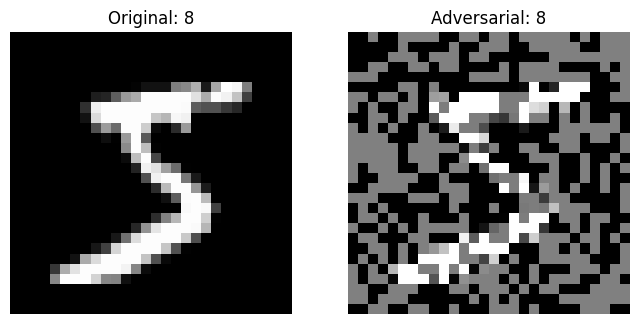

In [ ]:
# Create and train the model
model = SimpleNN()
print("Training model...")
model = train_model(model, train_loader, epochs=5)

# Test the trained model
print("\nTesting model...")
test_accuracy = test_model(model, test_loader)

In [ ]:
def fgsm_attack(model, image, label, epsilon):
    """
    Perform FGSM attack
    
    Args:
        model: The neural network
        image: Input image (requires gradient)
        label: True label
        epsilon: Perturbation magnitude
    
    Returns:
        perturbed_image: Adversarial example
    """
    # Forward pass
    output = model(image)
    loss = F.cross_entropy(output, label)
    
    # Backward pass to get gradients
    model.zero_grad()
    loss.backward()
    
    # Get the sign of the gradient
    data_grad = image.grad.data
    
    # Create adversarial example
    perturbed_image = image + epsilon * data_grad.sign()
    
    # Clamp to valid image range [0, 1]
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    return perturbed_image

In [ ]:
# Get a test image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# Select a sample from the test set
image, label = test_dataset[0]
image = image.unsqueeze(0).to(device)  # Add batch dimension
label = torch.tensor([label]).to(device)

# Enable gradient computation for the image
image.requires_grad = True

# Get original prediction
original_output = model(image)
original_pred = original_output.argmax(1).item()
original_confidence = F.softmax(original_output, dim=1).max().item()

print(f"Original prediction: {original_pred} (confidence: {original_confidence:.4f})")
print(f"True label: {label.item()}")

In [ ]:
# Try different epsilon values
epsilons = [0.0, 0.05, 0.1, 0.15, 0.2, 0.3]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for idx, epsilon in enumerate(epsilons):
    # Reset gradient
    if image.grad is not None:
        image.grad.zero_()
    
    # Generate adversarial example
    if epsilon == 0.0:
        adv_image = image
    else:
        adv_image = fgsm_attack(model, image, label, epsilon)
    
    # Get prediction on adversarial example
    with torch.no_grad():
        adv_output = model(adv_image)
        adv_pred = adv_output.argmax(1).item()
        adv_confidence = F.softmax(adv_output, dim=1).max().item()
    
    # Visualize
    axes[idx].imshow(adv_image.squeeze().cpu().detach().numpy(), cmap='gray')
    axes[idx].set_title(f'ε={epsilon}\nPred: {adv_pred} ({adv_confidence:.2f})', fontsize=10)
    axes[idx].axis('off')
    
    # Mark if attack succeeded
    if adv_pred != label.item():
        axes[idx].set_title(f'ε={epsilon}\nPred: {adv_pred} ({adv_confidence:.2f})\n✓ ATTACK SUCCESS', 
                           fontsize=10, color='red')

plt.suptitle(f'FGSM Attack - Original Label: {label.item()}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Generate adversarial example with epsilon = 0.1
epsilon = 0.1
image.requires_grad = True
if image.grad is not None:
    image.grad.zero_()

adv_image = fgsm_attack(model, image, label, epsilon)

# Get predictions
with torch.no_grad():
    original_output = model(image)
    adv_output = model(adv_image)

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(image.squeeze().cpu().detach().numpy(), cmap='gray')
axes[0].set_title(f'Original\nPrediction: {original_output.argmax(1).item()}\nTrue Label: {label.item()}', fontsize=12)
axes[0].axis('off')

# Adversarial image
axes[1].imshow(adv_image.squeeze().cpu().detach().numpy(), cmap='gray')
axes[1].set_title(f'Adversarial (ε={epsilon})\nPrediction: {adv_output.argmax(1).item()}', fontsize=12)
axes[1].axis('off')

# Perturbation (amplified for visibility)
perturbation = (adv_image - image).squeeze().cpu().detach().numpy()
axes[2].imshow(perturbation * 10, cmap='seismic', vmin=-1, vmax=1)
axes[2].set_title(f'Perturbation (×10)\nMax: {perturbation.max():.4f}', fontsize=12)
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"\nOriginal prediction: {original_output.argmax(1).item()}")
print(f"Adversarial prediction: {adv_output.argmax(1).item()}")
print(f"Attack {'succeeded' if original_output.argmax(1).item() != adv_output.argmax(1).item() else 'failed'}!")

In [ ]:
def evaluate_attack(model, test_loader, epsilon, max_samples=1000):
    """
    Evaluate attack success rate
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    correct_original = 0
    correct_adversarial = 0
    total = 0
    
    for images, labels in test_loader:
        if total >= max_samples:
            break
            
        images, labels = images.to(device), labels.to(device)
        images.requires_grad = True
        
        # Original predictions
        outputs = model(images)
        _, pred = outputs.max(1)
        correct_original += pred.eq(labels).sum().item()
        
        # Generate adversarial examples
        if epsilon > 0:
            loss = F.cross_entropy(outputs, labels)
            model.zero_grad()
            loss.backward()
            
            data_grad = images.grad.data
            perturbed_images = images + epsilon * data_grad.sign()
            perturbed_images = torch.clamp(perturbed_images, 0, 1)
        else:
            perturbed_images = images
        
        # Adversarial predictions
        with torch.no_grad():
            adv_outputs = model(perturbed_images)
            _, adv_pred = adv_outputs.max(1)
            correct_adversarial += adv_pred.eq(labels).sum().item()
        
        total += labels.size(0)
    
    original_acc = 100. * correct_original / total
    adversarial_acc = 100. * correct_adversarial / total
    
    return original_acc, adversarial_acc

# Test different epsilon values
epsilons_test = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
accuracies = []

print("Evaluating attack success rates...\n")
for eps in epsilons_test:
    orig_acc, adv_acc = evaluate_attack(model, test_loader, eps, max_samples=1000)
    accuracies.append((orig_acc, adv_acc))
    print(f"ε = {eps:.2f}: Original Acc = {orig_acc:.2f}%, Adversarial Acc = {adv_acc:.2f}%")

# Plot results
plt.figure(figsize=(10, 6))
orig_accs = [acc[0] for acc in accuracies]
adv_accs = [acc[1] for acc in accuracies]

plt.plot(epsilons_test, orig_accs, 'b-o', label='Original Accuracy', linewidth=2)
plt.plot(epsilons_test, adv_accs, 'r-o', label='Adversarial Accuracy', linewidth=2)
plt.xlabel('Epsilon', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('FGSM Attack: Model Accuracy vs Epsilon', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()